In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import pickle as pk
import os.path
import pandas as pd
from collections import (defaultdict,Counter)
import time
import matplotlib.pyplot as plt
import statistics

In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#Here, we import the lists of hub exposures, central module exposures, peripheric exposures and no hub no module exposures
hub_exposures_list=[]
central_module_exposures_list=[]
peripheric_module_exposures_list=[]
no_central_no_module_exposures_list=[]
 
# Using readlines()
file1 = open('output/Hub_expusres.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    hub_exposures_list.append(line.strip("\n"))

# Using readlines()
file1 = open('output/Central_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    central_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/Peripheric_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    peripheric_module_exposures_list.append(line.strip("\n"))
    
# Using readlines()
file1 = open('output/No_central_no_module_exposures.txt', 'r')
Lines = file1.readlines()
for line in Lines:
    no_central_no_module_exposures_list.append(line.strip("\n"))


In [4]:
len(set(hub_exposures_list+central_module_exposures_list+peripheric_module_exposures_list+no_central_no_module_exposures_list))

9852

In [5]:
len(set(hub_exposures_list+central_module_exposures_list))

5694

In [6]:
len(set(no_central_no_module_exposures_list))

3370

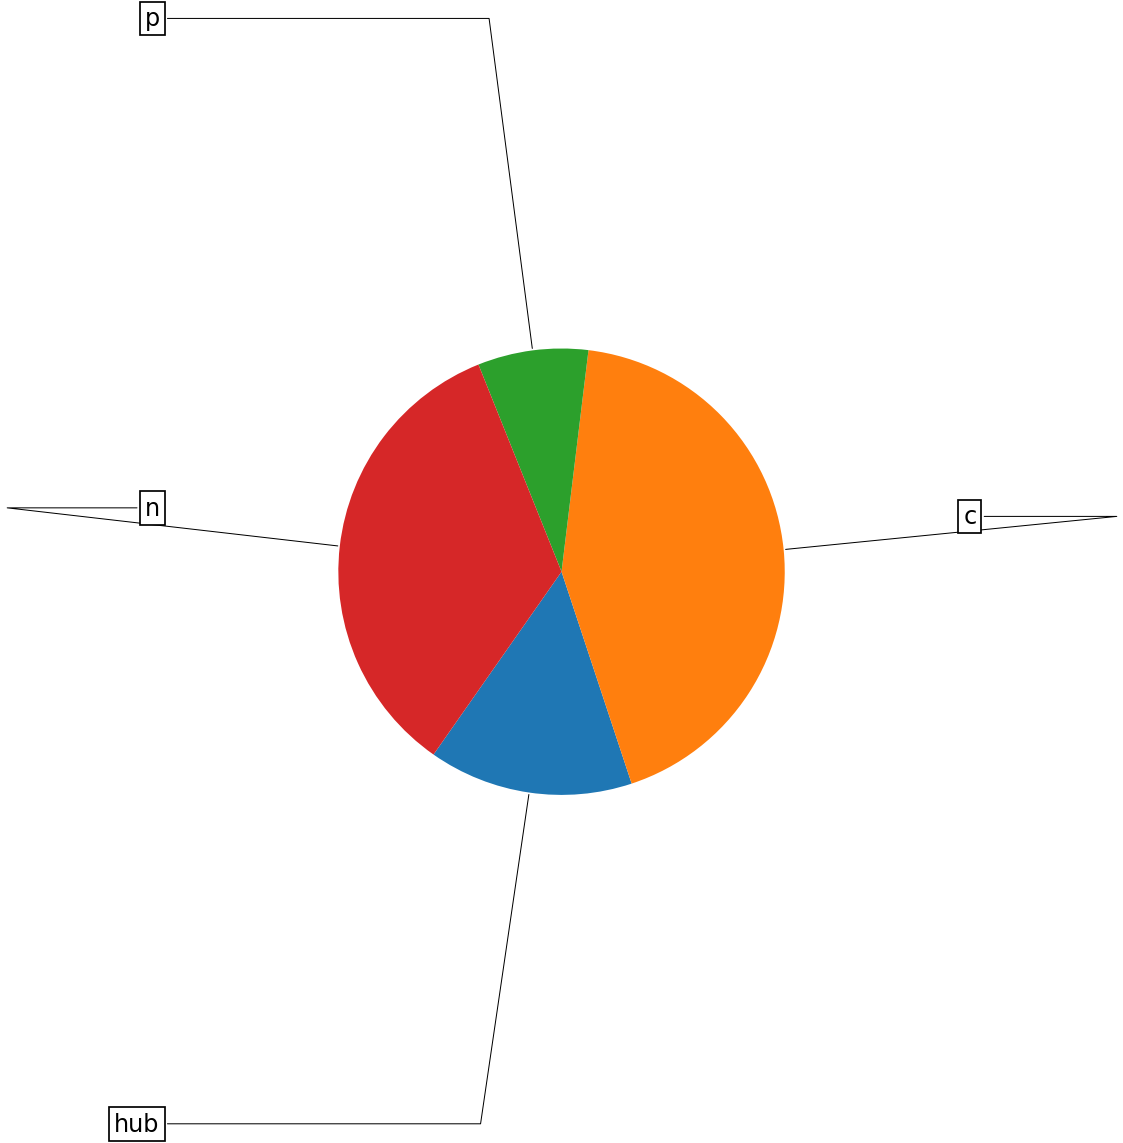

In [7]:
#Here, we show the proportion of the chemical classes in the entire CTD 
fig, ax = plt.subplots(figsize=(10, 20), subplot_kw=dict(aspect="equal"))
radius = 1

cmap = plt.cm.viridis



sizes=[len(hub_exposures_list),len(central_module_exposures_list),len(peripheric_module_exposures_list),len(no_central_no_module_exposures_list)]

wedges, texts = ax.pie(sizes, wedgeprops=dict(width=1), startangle=-125)

bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=1.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

#for i, p in enumerate(wedges):
#    ang = (p.theta2 - p.theta1)/2. + p.theta1
#    y = np.sin(np.deg2rad(ang))
#    x = np.cos(np.deg2rad(ang))
#    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#    kw["arrowprops"].update({"connectionstyle": connectionstyle})
#    ax.annotate(labels[i], xy=(x, y), xytext=(1.8*np.sign(x), 2.5*y),
                horizontalalignment=horizontalalignment,fontsize=24, **kw)
#plt.savefig('output/Figures/Figure3D.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

In [23]:
#Here, we import the merged PPI
ppi = pd.read_csv("input/PPI/autocore_symbol_lcc.csv",delimiter= ',',
           skipinitialspace=True)
G_ppi = nx.from_pandas_edgelist(ppi, 'symbol1', 'symbol2')
G_ppi_lcc = G_ppi.subgraph(max(nx.connected_components(G_ppi), key=len))  # extract lcc graph
print(G_ppi_lcc.number_of_nodes())
print(G_ppi_lcc.number_of_edges())

18815
482935


In [24]:
#Let's build some dictionaries
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])
        
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)           
    else:
        pass

chem_gene_dictio_cleaned_ppi={}
for k,v in chem_gene_cleaned.items():
    new_list=[]
    for gene in v:
        if gene in G_ppi_lcc.nodes():
            new_list.append(gene)
        else:
            pass
    if len(new_list)>0:
        chem_gene_dictio_cleaned_ppi[k]=new_list
    else:
        pass

#Let's build also the vice-versa: the gene-chem 
gene_chem = {}
for i,v in chem_homo.iterrows():
    try:
        gene_chem[v["GeneSymbol"]] |= {v["ChemicalID"]}
    except KeyError as e:
        gene_chem[v["GeneSymbol"]] = set([v["ChemicalID"]])
        
#Here the cleaning process
gene_chem_cleaned={}
for k,v in gene_chem.items():
    if len(v)!=0:
        gene_chem_cleaned[k]=v
    else:
        pass

In [21]:
#Let's import the median degree z-score
with open('output/exp_mediandegree_zscore.pickle', 'rb') as handle:
    exp_mediandegree_zscore = pk.load(handle)

with open('intermediate/final_exposome_zscore.pickle', 'rb') as handle:
    final_exposome_zscore = pk.load(handle)



In [33]:
exp_name = []
exp_type = []
exp_numgenes = []
exp_median_degree = []
exp_deg_zscore = []
exp_conn_zscore = []

for exp in hub_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Hub-exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")
    
for exp in central_module_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Central-module exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")

for exp in peripheric_module_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Peripheral-module exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")

for exp in no_central_no_module_exposures_list:
    genelist = chem_gene_dictio_cleaned_ppi[exp]
    deg_list = [G_ppi_lcc.degree(gene) for gene in genelist]
    exp_name.append(exp)
    exp_type.append("Scattered exposure")
    exp_numgenes.append(len(genelist))
    exp_median_degree.append(np.median(deg_list))
    try:
        exp_deg_zscore.append(exp_mediandegree_zscore[exp])
    except:
        exp_deg_zscore.append("nan")
    try:
        exp_conn_zscore.append(final_exposome_zscore[exp])
    except:
        exp_conn_zscore.append("nan")


exp_ppi_df = pd.DataFrame()
exp_ppi_df["Exposure ID"] = exp_name
exp_ppi_df["Type"] = exp_type
exp_ppi_df["Number of Perturbed Genes in the PPI"] = exp_numgenes
exp_ppi_df["Median Degree in the PPI"] = exp_median_degree
exp_ppi_df["Median Degree z-score"] = exp_deg_zscore
exp_ppi_df["Connectivity z-score"] = exp_conn_zscore

exp_ppi_df.to_csv("output/exp_ppi_df.tsv",sep="\t")

In [7]:
#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_cas_conversion = {}
for i,v in chem_homo.iterrows():
        chem_id_cas_conversion[v["ChemicalID"]] = v["CasRN"]

In [8]:
#Let's define a dictionary that will convert the chemical ID in chemical name
chem_id_name_conversion = {}
for i,v in chem_gene_df.iterrows():
        chem_id_name_conversion[v["ChemicalID"]] = v["# ChemicalName"]

In [20]:

with open('output/CTDNameID.txt', 'w') as f:  # Open file in write mode
    for chemname, chemid in chem_id_name_conversion.items():  # Iterate over key-value pairs in your dictionary
        f.write(str(chemname) + '\t' + str(chemid) + '\n')  

In [9]:
chem_id_name_conversion_inv={}
for k,v in chem_id_name_conversion.items():
    chem_id_name_conversion_inv[v]=k

In [10]:
chem_id_cas_conversion_inv={}
for k,v in chem_id_cas_conversion.items():
    chem_id_cas_conversion_inv[v]=k

In [14]:
#We are importing the toxicity data (Hazard) from NORMANN (Susdata0), this was updated at 18.01.2022
#(https://www.norman-network.com/nds/SLE/)
#We will use the hazard value 'HazScore_EcoChronic_KEMI', which ranges from 0 (no toxic) to 1 (super harmful)
#this score was calculated based on the hazard in ecosystem and as chronic exposures and it was reported by
#KEMI Market list, a list of the 30418 chemical compounds that are available in the EU market
#https://comptox.epa.gov/dashboard/chemical-lists/KEMIMARKET


susdat_toxicity_df=pd.read_excel('input/NORMANN/susdat_2022-01-18-104316.xlsx', index_col=0)  

In [16]:
susdat_toxicity_ctd_full_dict = {}

susdat_toxicity_name_low_dict = {}
for i in susdat_toxicity_df['Name'].tolist():
    susdat_toxicity_name_low_dict[i.lower()] = i
    
susdat_toxicity_name_dash_low_dict = {}
for i in susdat_toxicity_df['Name_Dashboard'].tolist():
    susdat_toxicity_name_dash_low_dict[str(i).lower()] = i

susdat_toxicity_name_chem_low_list = {}
for i in susdat_toxicity_df['Name_ChemSpider'].tolist():
    susdat_toxicity_name_chem_low_list[str(i).lower()] = i

susdat_toxicity_name_iupac_low_list = {}
for i in susdat_toxicity_df['Name_IUPAC'].tolist():
    susdat_toxicity_name_iupac_low_list[str(i).lower()] = i

susdat_toxicity_name_chemsyn_low_list = {}
for i in susdat_toxicity_df['Synonyms_ChemSpider'].tolist():
    susdat_toxicity_name_chemsyn_low_list[str(i).lower()] = i

for chem_na,chem_id in chem_id_name_conversion_inv.items():
    chem_name = chem_na.lower()
    try:
        haz=susdat_toxicity_df[susdat_toxicity_df['Name']==susdat_toxicity_name_low_dict[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
        susdat_toxicity_ctd_full_dict[chem_id]=haz
    except:
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['Name_Dashboard']==susdat_toxicity_name_dash_low_dict[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
            susdat_toxicity_ctd_full_dict[chem_id]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['Name_ChemSpider']==susdat_toxicity_name_chem_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                susdat_toxicity_ctd_full_dict[chem_id]=haz
            except:
                try:
                    haz=susdat_toxicity_df[susdat_toxicity_df['Name_IUPAC']==susdat_toxicity_name_iupac_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                    susdat_toxicity_ctd_full_dict[chem_id]=haz
                except:
                    try:
                        haz=susdat_toxicity_df[susdat_toxicity_df['Synonyms_ChemSpider']==susdat_toxicity_name_chemsyn_low_list[chem_name]]['HazScore_EcoChronic_KEMI'].values[0]
                        susdat_toxicity_ctd_full_dict[chem_id]=haz
                    except:
                        pass

for chem_cas,chem_id in chem_id_cas_conversion_inv.items():
    if chem_id not in susdat_toxicity_ctd_full_dict.keys():    
        try:
            haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN']=="CAS_RN:"+chem_cas]['HazScore_EcoChronic_KEMI'].values[0]
            susdat_toxicity_ctd_full_dict[exp]=haz
        except:
            try:
                haz=susdat_toxicity_df[susdat_toxicity_df['CAS_RN_Dashboard']==chem_cas]['HazScore_EcoChronic_KEMI'].values[0]
                susdat_toxicity_ctd_full_dict[exp]=haz
            except: 
                pass


print(len(susdat_toxicity_ctd_full_dict))


4668


In [34]:
len(susdat_toxicity_ctd_full_dict)/len(chem_gene_dictio_cleaned_ppi)

0.47381242387332523

In [35]:
hub_exposures_haz_dict={}
for exp in hub_exposures_list:
    try:
        hub_exposures_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

peripheric_module_haz_dict={}
for exp in peripheric_module_exposures_list:
    try:
        peripheric_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

central_module_haz_dict={}
for exp in central_module_exposures_list:
    try:
        central_module_haz_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

no_central_no_module_exposures_dict={}
for exp in no_central_no_module_exposures_list:
    try:
        no_central_no_module_exposures_dict[exp] = susdat_toxicity_ctd_full_dict[exp]
    except:
        pass

print("This is the ratio of found exposures with hazard annotation for hub exposures: %s" %(len(hub_exposures_haz_dict)/len(hub_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for central module exposures: %s" %(len(central_module_haz_dict)/len(central_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for peripheric module exposures: %s" %(len(peripheric_module_haz_dict)/len(peripheric_module_exposures_list)))
print("This is the ratio of found exposures with hazard annotation for no module no hub exposures: %s" %(len(no_central_no_module_exposures_dict)/len(no_central_no_module_exposures_list)))


This is the ratio of found exposures with hazard annotation for hub exposures: 0.35435229609321456
This is the ratio of found exposures with hazard annotation for central module exposures: 0.40920897284533647
This is the ratio of found exposures with hazard annotation for peripheric module exposures: 0.40609137055837563
This is the ratio of found exposures with hazard annotation for no module no hub exposures: 0.36112759643916914


In [59]:
import pandas as pd
column_names = ["Hazard", "Group"]

haz_count_df = pd.DataFrame(columns = column_names)

for val in list(hub_exposures_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Hub"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(central_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Central Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
for val in list(peripheric_module_haz_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Peripheral Module"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)
    
    
for val in list(no_central_no_module_exposures_dict.values()):
    if str(val)!='nan':
        new_row={"Hazard":val,"Group":"Scattered"}
        haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/2399414858.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  haz_count_df = pd.concat([haz_count_df, pd.DataFrame([new_row])], ignore_index=True)


In [82]:
from itertools import combinations
pairs = list(combinations(list(set(haz_count_df['Group'])), r=2))


#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

list_palette=list(sns.color_palette())

my_pal = {"Central Module":list_palette[1] , "Hub": list_palette[0], "Peripheral Module":list_palette[2], "Scattered":list_palette[3]}


g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)

ax.grid(False)

plt.savefig('output/Figures/Fig3G_v06.pdf',format='pdf',dpi=300, bbox_inches = "tight")

plt.show()

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/1485264548.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=haz_count_df,x="Group", y="Hazard",order=["Central Module","Hub","Peripheral Module","Scattered"],palette=my_pal,linewidth=5)


In [48]:
#Let's make some statistics
import scipy

hub_haz_list_cleaned = [i for i in list(hub_exposures_haz_dict.values()) if str(i)!='nan']
nocentral_nomodule_haz_list_cleaned = [i for i in list(no_central_no_module_exposures_dict.values()) if str(i)!='nan']
peripheric_module_haz_list_cleaned = [i for i in list(peripheric_module_haz_dict.values()) if str(i)!='nan']
central_module_haz_list_cleaned = [i for i in list(central_module_haz_dict.values()) if str(i)!='nan']



print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(peripheric_module_haz_list_cleaned, nocentral_nomodule_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(central_module_haz_list_cleaned, peripheric_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))

print(scipy.stats.mannwhitneyu(hub_haz_list_cleaned, central_module_haz_list_cleaned, use_continuity=True, alternative='two-sided'))




MannwhitneyuResult(statistic=226838.5, pvalue=0.02428842344923827)
MannwhitneyuResult(statistic=866277.5, pvalue=6.185817331272729e-16)
MannwhitneyuResult(statistic=125361.5, pvalue=0.28454259895208334)
MannwhitneyuResult(statistic=245288.5, pvalue=1.7545824498236355e-09)
MannwhitneyuResult(statistic=282843.5, pvalue=0.00013957768411437826)


In [19]:
susdat_toxicity_df[susdat_toxicity_df['Name']=='Endrin ']['HazScore_EcoChronic_KEMI'].values[0]

0.31

In [45]:
for exp,haz in hub_exposures_haz_dict.items():
    if haz<=0.3:
        if len(chem_gene_dictio_cleaned_ppi[exp])<20:
            if len(set(chem_gene_dictio_cleaned_ppi['D004732'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                if len(set(chem_gene_dictio_cleaned_ppi['D014641'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                    G_ppi_sub = G_ppi.subgraph(chem_gene_dictio_cleaned_ppi[exp]) 
                    if G_ppi_sub.number_of_edges()>4:
                        for gene in chem_gene_dictio_cleaned_ppi[exp]:
                            if nx.degree(G_ppi,gene)>50:
                                print(exp,haz)


C027667 0.15
C027667 0.15
C027667 0.15
C036758 0.17
C036758 0.17
C036758 0.17
C055802 0.13
C055802 0.13
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
C030735 0.1
D000086 0.1
D000086 0.1
C031800 0.04
C031800 0.04
D019386 0.08
D019386 0.08
D019386 0.08
D019386 0.08
D019386 0.08
D000583 0.17
D000583 0.17
D000583 0.17
D000641 0.27
D000641 0.27
D000641 0.27
D000641 0.27
D000641 0.27
D000658 0.08
C018861 0.13
C018861 0.13
C019304 0.12
C019304 0.12
C019304 0.12
C019304 0.12
C019304 0.12
C007078 0.18
C007078 0.18
C007078 0.18
C007078 0.18
D004977 0.03
D004977 0.03
D005280 0.01
D005280 0.01
D005280 0.01
D005280 0.01
D000077604 0.04
D000077604 0.04
D000077604 0.04
D019807 0.04
D019807 0.04
D019807 0.04
D019807 0.04
D020366 0.27
D020105 0.1
D020105 0.1
D020105 0.1
D009583 0.04
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
C023844 0.14
D011441 0.16
D011441 0.16
D011441 0.16
D011441 0.16
D011441 0.16
D0

In [46]:
# open file in write mode
with open('output/Methylmethacrylate.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D020366']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [34]:
# open file in write mode
with open('output/Benthiocarb.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['C037925']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [42]:
for exp,haz in peripheric_module_haz_dict.items():
    if haz<=0.2:
        if len(chem_gene_dictio_cleaned_ppi[exp])<20 and len(chem_gene_dictio_cleaned_ppi[exp])>3:
            if len(set(chem_gene_dictio_cleaned_ppi['D004732'])&set(chem_gene_dictio_cleaned_ppi[exp]))<1:
                G_ppi_sub = G_ppi.subgraph(chem_gene_dictio_cleaned_ppi[exp]) 
                if G_ppi_sub.number_of_edges()>10:
                    print(exp,haz)

D015104 0.04
C035253 0.01
D001640 0.1
C075375 0.01
D006923 0.02
D008717 0.01
D010852 0.02
D012603 0.01
D014641 0.01


In [43]:
# open file in write mode
with open('output/Vanillic_acid.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D014641']:
        # write each item on a new line
        fp.write("%s\n" % item)

In [33]:
# open file in write mode
with open('output/Diflubenzuron.txt', 'w') as fp:
    for item in chem_gene_dictio_cleaned_ppi['D004132']:
        # write each item on a new line
        fp.write("%s\n" % item)


In [49]:
np.max(central_module_haz_list_cleaned)

1.0

In [50]:
np.max(hub_haz_list_cleaned)

0.63

In [51]:
np.max(nocentral_nomodule_haz_list_cleaned)

0.57

In [52]:
np.max(peripheric_module_haz_list_cleaned)

0.56

In [53]:
np.median(central_module_haz_list_cleaned)

0.13

In [54]:
np.median(hub_haz_list_cleaned)

0.11

In [55]:
np.median(nocentral_nomodule_haz_list_cleaned)

0.09

In [56]:
np.median(peripheric_module_haz_list_cleaned)

0.08

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/2142357301.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Group", y="Hazard", data=haz_count_df,


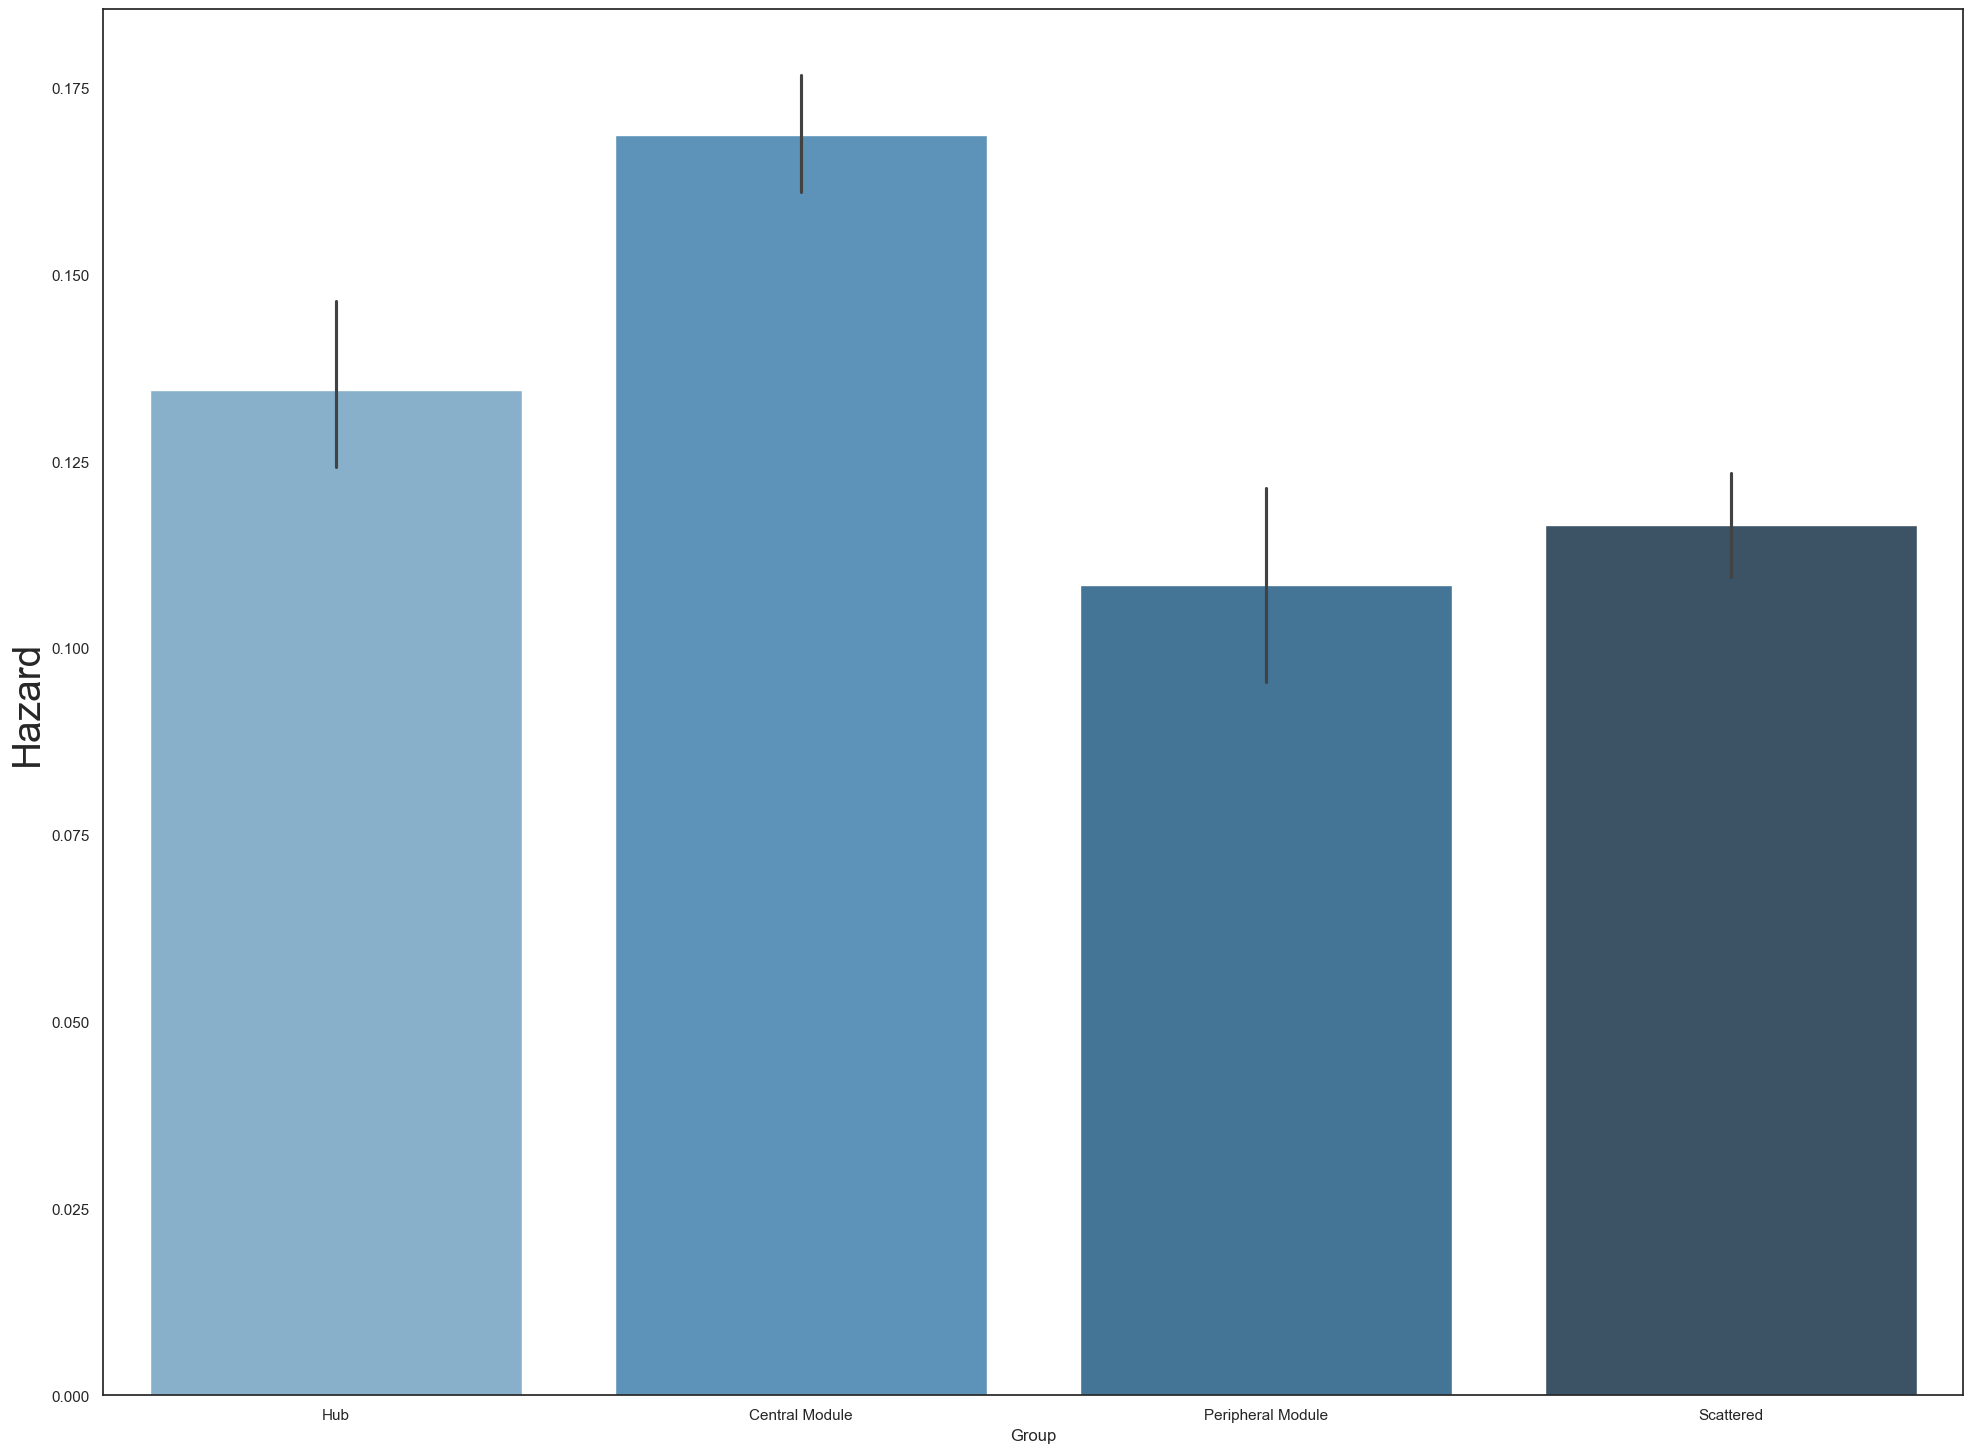

In [61]:
#Let's visualize as barplots
fig, ax = plt.subplots(figsize=(24, 18))
ax = sns.barplot(x="Group", y="Hazard", data=haz_count_df,
                 palette="Blues_d",estimator=np.mean)
#ax.set_yscale("log")
ax.set_ylabel("Hazard",fontsize=28)
#ax.set_xlabel("Group",fontsize=28)
plt.show()

In [62]:
#We do not observe any positive correlation between the median degree value and the Hazard, let's try considering
#the max degree

def max_degree(genelist):
    degree_list=[]
    for gene in genelist:
        degree_list.append(G_ppi_lcc.degree(gene))
    max_degree=max(degree_list)
    return max_degree

chem_max_degree={}
for chem, genelist in chem_gene_dictio_cleaned_ppi.items():
    chem_max_degree[chem]=max_degree(genelist)

In [66]:
#Then, we will make a correlation plot to visualize whether there is a positive correlation between degree and hazard
import scipy

max_deg_list=[]
haz_list=[]
for chem,haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz)!='nan':
        try:
            max_deg_list.append(chem_max_degree[chem])
            haz_list.append(haz)
        except:
            pass


print(scipy.stats.pearsonr(max_deg_list,haz_list))  # Pearson's r
print(scipy.stats.spearmanr(max_deg_list,haz_list)) # Spearman's rho



PearsonRResult(statistic=0.23893893127169047, pvalue=2.4814094375987696e-42)
SignificanceResult(statistic=0.1902223618902743, pvalue=3.5920536381089665e-27)


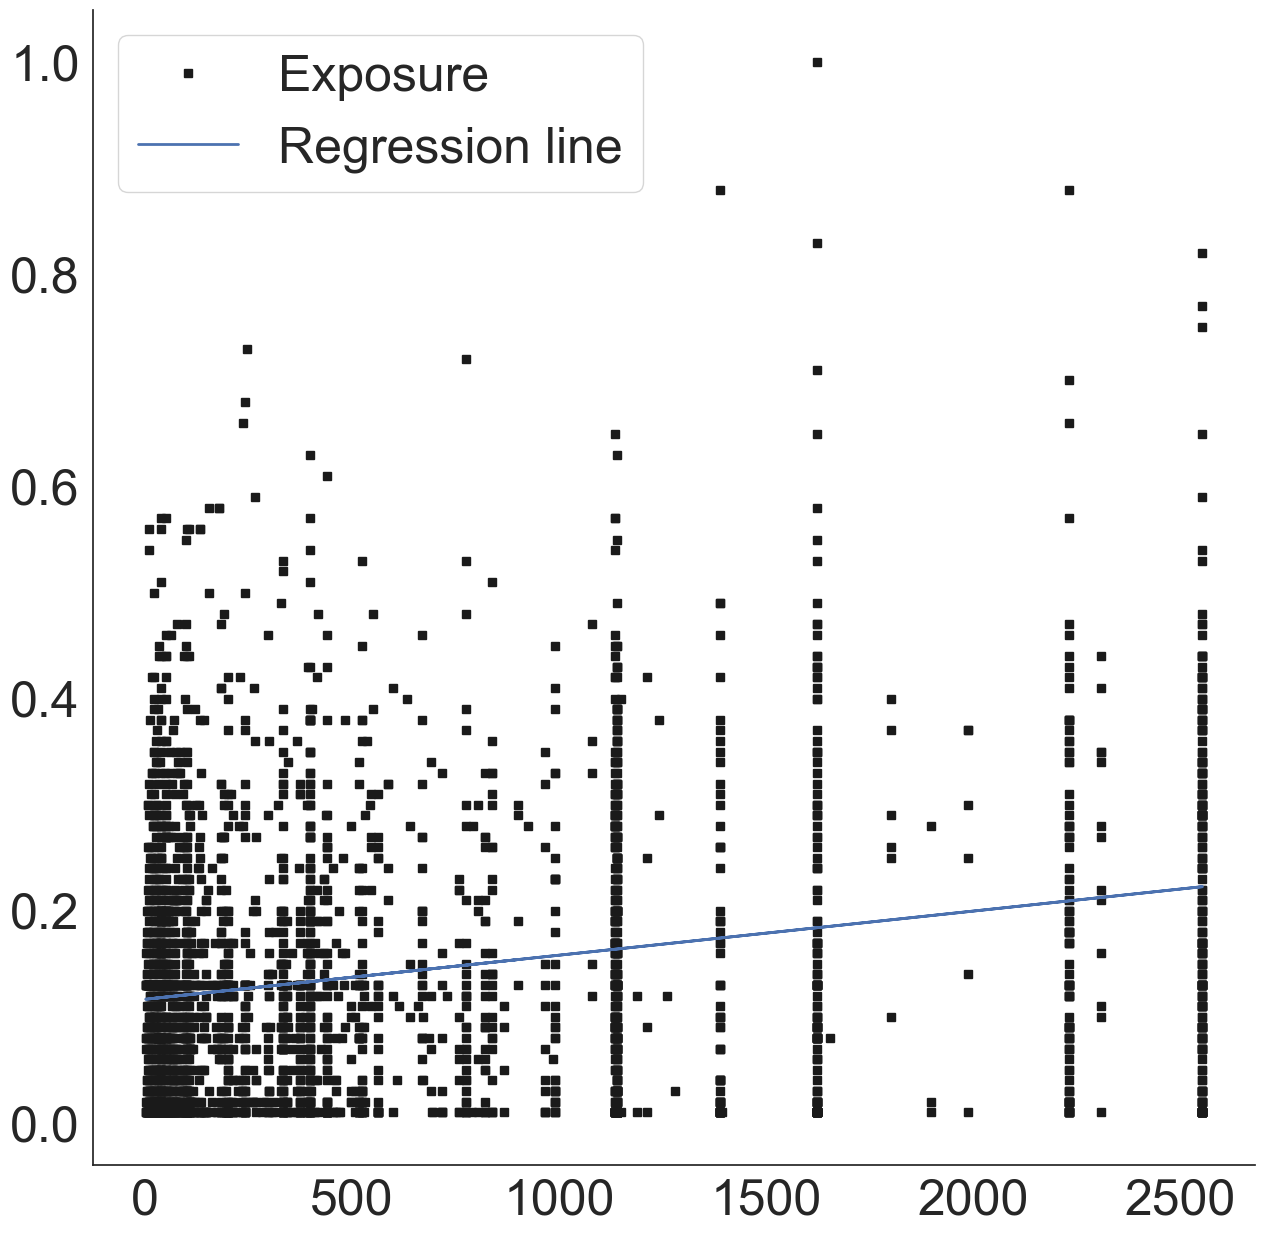

In [67]:

import scipy
from matplotlib.pyplot import figure
from scipy import stats


fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(max_deg_list, haz_list)

ax.plot(max_deg_list,haz_list, linewidth=0, marker='s',c='k', label='Exposure')
y=[]
for i in max_deg_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(max_deg_list, y, label=line,linewidth=2)
#ax.set_xlabel('Max degree value', fontsize=18)
#ax.set_ylabel('Hazard',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/Figure3Fv2.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [77]:
column_names = ["Hazard", "Degree"]

deg_haz_df = pd.DataFrame(columns = column_names)
deg_haz_df['Hazard']=haz_list
deg_haz_df['Degree']=max_deg_list

In [78]:
deg_haz_df_sort_by_degree=deg_haz_df.sort_values("Degree")

In [79]:
cat_list=[]
for i in range(len(deg_haz_df_sort_by_degree)):
    if i<len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("1st quintile")
    elif i>len(deg_haz_df_sort_by_degree)/5 and i<2*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(deg_haz_df_sort_by_degree)/5 and i<3*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(deg_haz_df_sort_by_degree)/5 and i<4*len(deg_haz_df_sort_by_degree)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
deg_haz_df_sort_by_degree["Group"]=cat_list

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_7320/349719640.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)


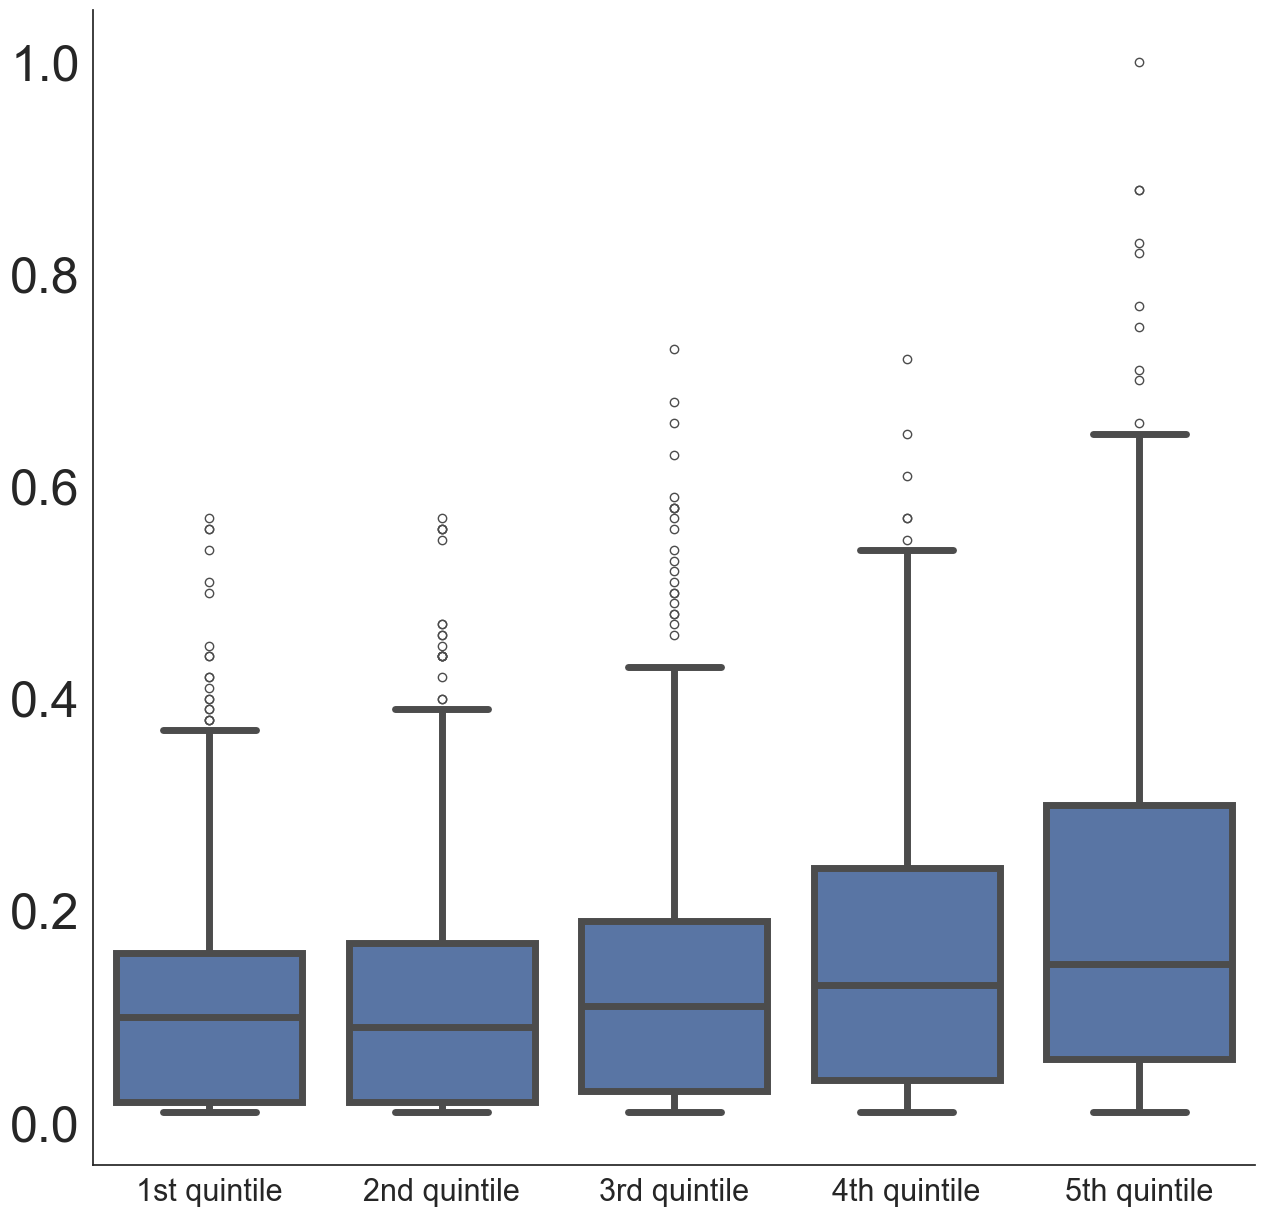

In [81]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=deg_haz_df_sort_by_degree,x="Group", y="Hazard",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([round(i,2) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
plt.savefig('output/Figures/Fig3H_v06.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()


In [83]:
exp_name = []
exp_type = []
max_deg_list=[]
haz_list=[]
for chem,haz in susdat_toxicity_ctd_full_dict.items():
    if str(haz)!='nan':
        try:
            max_deg_list.append(chem_max_degree[chem])
            haz_list.append(haz)
            exp_name.append(chem)
            if chem in hub_exposures_list:
                exp_type.append("Hub-exposure")
            elif chem in central_module_exposures_list:
                exp_type.append("Central-module exposure")
            elif chem in peripheric_module_exposures_list:
                exp_type.append("Peripheral-module exposure")
            else:
                 exp_type.append("Scattered exposure")
        except:
            pass

exp_haz_df = pd.DataFrame()
exp_haz_df["Exposure ID"] = exp_name
exp_haz_df["Type"] = exp_type
exp_haz_df["Max degree in the PPI"] = max_deg_list
exp_haz_df["Hazard"] = haz_list
exp_haz_df.to_csv("output/exp_haz_df.tsv",sep="\t")